<a href="https://colab.research.google.com/github/thecalebe00/Portfolio-Optimization/blob/main/Portfolio_Optimization_FGV_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Otimização de Portfolio** - Projeto FGV Quant

Este projeto tem por objetivo a otimização de carteiras de ações através de minimização de riscos (Sharpe Ratio), utilizando conceitos de Fronteira Eficiente de Markowitz e demais ferramentas.

Autor: **Calebe Soares**

In [ ]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
!pip install yfinance #biblioteca para importação dos dados das ações
import yfinance as yf
!pip install pyportfolioopt #biblioteca a ser utilzada para otimização da carteira

# Seleção de ativos e plotagem do retorno por cada ação da carteira

Digite quais são os ativos que vão compor sua carteira: petz3,pgmn3,cogn3,tasa4,pcar3
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


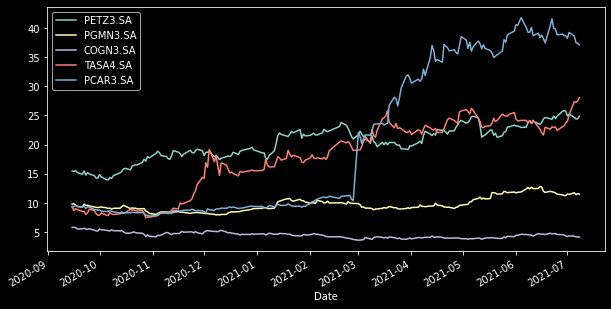

In [2]:
#Seleção de ativos
ativos = input("Digite quais são os ativos que vão compor sua carteira: ").upper().split(",")
ativos = [ticker + ".SA" for ticker in ativos]

#Com as devidas bibliotecas instaladas, agora iremos fazer a composição da carteira pelas ações escolhidas
carteira = pd.DataFrame()
for i in ativos:
  carteira[i] = yf.download(i,period="2y")['Adj Close']

#Com as devidas bibliotecas instaladas, agora iremos fazer a composição da carteira pelas ações escolhidas
carteira = pd.DataFrame()
for i in ativos:
  carteira[i] = yf.download(i,period="2y")['Adj Close']

#Visualização dos retornos das ações
plt.style.use('dark_background')
carteira.plot(figsize=(10,5))

# Cálculos do retorno da carteira e a matriz de covariância

In [4]:
#Para a realização da fronteira eficiente, é necessário a realização do retorno esperado e da matriz de covariação
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
er = mean_historical_return(carteira) #Retorno esperado da carteira
sd = CovarianceShrinkage(carteira).ledoit_wolf() #Matriz de covariância
sd

,PETZ3.SA,PGMN3.SA,COGN3.SA,TASA4.SA,PCAR3.SA
PETZ3.SA,0.554029,0.000000,0.000000,0.000000,0.000000
PGMN3.SA,0.000000,0.554029,0.000000,0.000000,0.000000
COGN3.SA,0.000000,0.000000,0.554029,-0.000000,0.000000
TASA4.SA,0.000000,0.000000,-0.000000,0.554029,-0.000000
PCAR3.SA,0.000000,0.000000,0.000000,-0.000000,0.554029


# Alocação da carteira nos ativos de acordo a maximização do Índice de Sharpe  
 Visão geral do retorno esperado da carteira, volatilidade e Sharpe Ratio do portfolio

In [5]:
#Com a matriz de covariação e o retorno esperado das ações da carteira, agora calculamos a porcentagemd e alocação em cada posição da carteira
from pypfopt.efficient_frontier import EfficientFrontier
ef = EfficientFrontier(er,sd)
composicao = ef.max_sharpe(risk_free_rate=0.0425)

#Visão geral
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('PETZ3.SA', 0.08977), ('PGMN3.SA', 0.02136), ('COGN3.SA', 0.0), ('TASA4.SA', 0.34127), ('PCAR3.SA', 0.5476)])
Expected annual return: 377.9%
Annual volatility: 48.5%
Sharpe Ratio: 7.70


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:412: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


(3.7794865154786916, 0.4851565802399631, 7.702640070614609)

In [6]:
#Como houveram posições com peso igual a 0, houve o rebalanceamento de modo a ponderar melhor as posições da carteira
from pypfopt import objective_functions

ef = EfficientFrontier(er, sd)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
w = ef.max_sharpe()
ef.clean_weights()

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('PETZ3.SA', 0.0914),
             ('PGMN3.SA', 0.02367),
             ('COGN3.SA', 0.0),
             ('TASA4.SA', 0.34035),
             ('PCAR3.SA', 0.54458)])

# Quantidade de ações a serem compradas de acordo com o patrimônio do portfolio

In [7]:
#Quantidade de ações a serem compradas de acordo com o valor de seu portfolio
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
portfolio_value = float(input("Qual o valor do seu portfolio? * Digite apenas o numero, sem vírgulas e pontos *"))
latest_prices = get_latest_prices(carteira)
da = DiscreteAllocation(w, latest_prices, portfolio_value)
allocation, leftover = da.lp_portfolio()
print(allocation)

Qual o valor do seu portfolio? * Digite apenas o numero, sem vírgulas e pontos *10000
{'PETZ3.SA': 37, 'PGMN3.SA': 20, 'COGN3.SA': 1, 'TASA4.SA': 121, 'PCAR3.SA': 147}


# Plotagem da fronteria eficiente

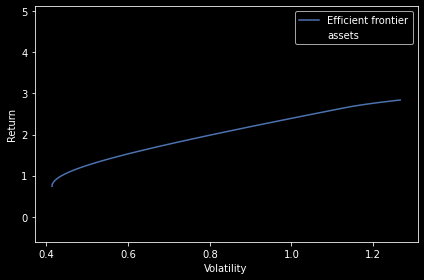

In [8]:
#Plotagem da Fronteira eficiente
from pypfopt import plotting
ef = EfficientFrontier(er, sd, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

# Fronteria eficiente com Índice de Sharpe maximizado e geração de portfolios aleatórios para a fronteira

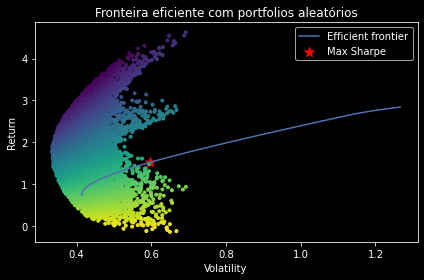

In [9]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Geração de portfolios aleatórios, para a composição da fronteira
n_samples = 10000
w = np.random.dirichlet(np.ones(len(er)), n_samples)
rets = w.dot(er)
stds = np.sqrt(np.diag(w @ sd @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Resultado
ax.set_title("Fronteira eficiente com portfolios aleatórios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

# Backtesting

In [ ]:
!pip install bt

KeyError: ignored

In [66]:
import bt
juros = float(input("Qual a taxa de juros? *Digite separando as casas decimais como pontos* "))
rebalancing = bt.Strategy("Rebalanceamento", [bt.algos.RunMonthly(run_on_end_of_period=True),
                                                bt.algos.SelectAll(),
                                                bt.algos.WeighSpecified(**composicao),
                                                bt.algos.Rebalance()])

buyhold = bt.Strategy("Buy & Hold",[bt.algos.RunOnce,
                                    bt.algos.SelectAll(),
                                    bt.algos.WeighSpecified(**composicao),])

bt1 = bt.Backtest(rebalancing, carteira)
bt2 = bt.Backtest(buyhold, carteira)

Qual a taxa de juros? *Digite separando as casas decimais como pontos* 4.5


Stat                 Rebalanceamento
-------------------  -----------------
Start                2020-09-14
End                  2021-07-08
Risk-free rate       0.00%

Total Return         285.05%
Daily Sharpe         2.49
Daily Sortino        11.03
CAGR                 424.90%
Max Drawdown         -14.91%
Calmar Ratio         28.50

MTD                  3.86%
3m                   17.65%
6m                   196.91%
YTD                  203.16%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  424.90%

Daily Sharpe         2.49
Daily Sortino        11.03
Daily Mean (ann.)    194.92%
Daily Vol (ann.)     78.19%
Daily Skew           9.74
Daily Kurt           120.72
Best Day             61.92%
Worst Day            -5.56%

Monthly Sharpe       1.84
Monthly Sortino      34.41
Monthly Mean (ann.)  230.36%
Monthly Vol (ann.)   125.44%
Monthly Skew         2.55
Monthly Kurt         6.89
Best Month           115.92%
Worst Month     

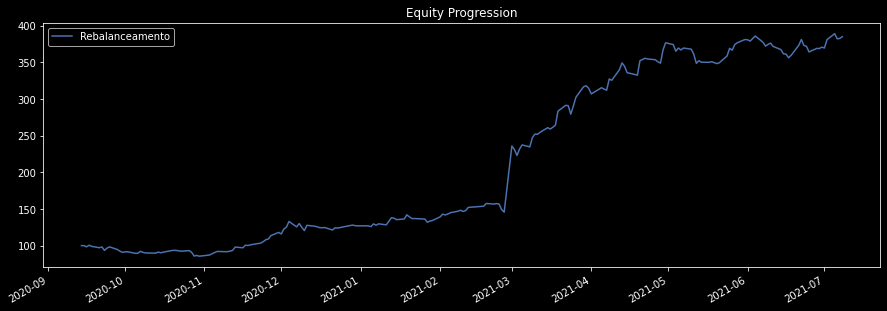

In [67]:
result1 = bt.run(bt1)
result1.display()
result1.plot()

In [68]:
result2 = bt.run(bt2)
result2.display()
result2.plot()

TypeError: ignored

In [14]:
import bt

def consulta_bc(codigo_bc):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bc)
  df = pd.read_json(url)
  df['data'] =pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

def cdi_acumulado(data_inicio, data_fim):
  cdi = consulta_bc(12)
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100 ).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

data_inicio = '2016-01-01' 
data_fim = '2021-07-09'

cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)
carteira['Renda Fixa'] = cdi
carteira.dropna(inplace=True)
carteira

,PETZ3.SA,PGMN3.SA,COGN3.SA,TASA4.SA,PCAR3.SA,Renda Fixa
Date,,,,,,
2020-09-15,15.460991,9.78,5.80,9.360000,9.241016,1.444058
2020-09-16,15.411117,9.87,5.83,8.660000,9.394949,1.444166
2020-09-17,15.560740,9.60,5.77,9.020000,9.541373,1.444273
2020-09-18,15.201645,9.38,5.53,8.850000,9.423734,1.444381
2020-09-21,14.912375,9.30,5.56,8.540000,9.329870,1.444489
...,...,...,...,...,...,...
2021-07-02,25.230000,11.45,4.34,25.100000,39.209999,1.471087
2021-07-05,24.660000,11.73,4.30,27.360001,38.580002,1.471325
2021-07-06,24.389999,11.41,4.17,27.230000,37.480000,1.471562


In [ ]:
rebalanceamento = bt.Strategy('Rebalanceamento',
                              [bt.algos.RunMonthly(run_on_end_of_period=True),
                               bt.algos.SelectAll(),
                               bt.algos.WeighMeanVar(covar_method='ledoit-wolf'),
                               bt.algos.Rebalance()])

buy_hold = bt.Strategy('Buy & Hold',
                       [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighMeanVar(),
                       bt.algos.Rebalance()])

bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira)
resultado = bt.run(bt1, bt2)
resultado.display()

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:211: RuntimeWarning: Mean of empty slice.
  X = X - X.mean(0)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:219: RuntimeWarning: invalid value encountered in true_divide
  emp_cov_trace = np.sum(X2, axis=0) / n_samples
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:241: RuntimeWarning: invalid value encountered in double_scalars
  delta_ /= n_samples ** 2


ZeroDivisionError: ignored